
# Physician Conversion Model

This is a modeling pipeline for predicting whether a physician will convert to a new platform. The pipeline consists of the following steps:

1. Split the data into train, validation, and inference sets.
2. Train a variety of models without hyperparameter tuning (vanilla models).
3. Select one of the vanilla models and tune its hyperparameters.
4. Evaluate the model on the inference set.

## Step 1: Split Data into Train, Validation, and Inference Sets

The data was split into 70% train, 20% validation, and 10% inference sets. This ensures that we have enough data to train the model, validate the model, and evaluate the model on unseen data.

## Step 2: Train Vanilla Models

A variety of vanilla models were trained, including logistic regression, decision trees, and random forests. These models were trained without hyperparameter tuning.

## Step 3: Select a Model

One of the vanilla models (----) was selected for hyperparameter tuning. The hyperparameters that were tuned include the learning rate and the regularization strength.

## Step 4: Evaluate the Model

The tuned model was evaluated on the validation set. The model achieved a high F1-score, indicating that it is able to predict whether a physician will convert to a new platform with a high degree of accuracy.

## Conclusion

The modeling pipeline described in this document was able to achieve a high F1-score on the validation set. This suggests that the model is able to predict whether a physician will convert to a new platform with a high degree of accuracy.

## Next Step

The final/selected model will be used in Inference Pipeline to do predition on Inference set

### Import Libraries and Model Input Dataset

In [129]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing necessary libraries for encoding
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Importing necessary library for scaling
from sklearn.preprocessing import StandardScaler

# Importing necessary library for train-test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Importing necessary libraries for model development and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Tuning
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
import os



import sagemaker
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from sagemaker.experiments.run import Run, load_run
from sagemaker.utils import unique_name_from_base
from sagemaker.session import Session

### Loading Data

In [130]:
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
feature_group_name = "physician-conversion-feature-group-30-14-22-46"

# Create a SageMaker session
sagemaker_session = sagemaker.Session()

# Load the feature group
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker_session)

In [131]:
query = feature_group.athena_query()
database = query.database
table_name = query.table_name
print(database)
print('')
print(table_name)

sagemaker_featurestore

physician_conversion_feature_group_30_14_22_46_1714486966


In [132]:
bucket = "sagemaker-experiment-hs/"
prefix = "Feature-store-trial"

In [133]:
query_string = 'SELECT * FROM "{}"."{}"'.format(database, table_name)
query.run(
    query_string=query_string,
    output_location='s3://sagemaker-experiment-hs/Feature-store-trial/'
)
query.wait()
dataset = query.as_dataframe()


INFO:sagemaker:Query 5aadf4c6-2134-414a-af88-9ab46df3270c is being executed.


INFO:sagemaker:Query 5aadf4c6-2134-414a-af88-9ab46df3270c successfully executed.


In [134]:
dataset.head()

,npi_id,hcp_id,target,age,year_of_experience,number_of_rx,rx_last_1_month,rx_last_3_month,rx_last_6_month,rx_last_12_month,...,specialty_oncology,specialty_pediatric,specialty_uro-oncology,hco_affiliation_type_contract,hco_affiliation_type_employment,hco_affiliation_type_referral,eventtime,write_time,api_invocation_time,is_deleted
0,9851763,HCP_4,1,74,35,392,704,1036,1078,1184,...,False,True,False,False,False,False,1.714487e+09,2024-04-30 14:28:40.525,2024-04-30 14:23:28.000,False
1,5764497,HCP_22,1,50,53,1100,1451,1638,2815,4920,...,False,False,False,False,True,False,1.714487e+09,2024-04-30 14:28:40.525,2024-04-30 14:23:28.000,False
2,2642428,HCP_35,0,71,34,1100,1544,2118,3672,6981,...,False,False,False,False,True,False,1.714487e+09,2024-04-30 14:28:40.525,2024-04-30 14:23:29.000,False
3,9970218,HCP_37,0,86,10,802,1515,2647,3683,5465,...,False,False,True,False,False,False,1.714487e+09,2024-04-30 14:28:40.525,2024-04-30 14:23:29.000,False
4,7358244,HCP_46,0,31,45,1100,1458,2463,3684,5433,...,False,False,False,False,False,False,1.714487e+09,2024-04-30 14:28:40.525,2024-04-30 14:23:29.000,False


### Load model features from s3

In [135]:
import pickle
import boto3

# Initialize the S3 client
s3 = boto3.client('s3')

# Specify the bucket name and the key (file path) of the pickle file in S3
bucket_name = 'sagemaker-experiment-hs'
key = 'processed_output//model_train_col_list.pkl'

# Load the pickle file from S3
response = s3.get_object(Bucket=bucket_name, Key=key)

# Read the content of the pickle file
pickle_bytes = response['Body'].read()

# Load the pickle bytes into a Python object
model_var_list = pickle.loads(pickle_bytes)

# Now you can use the loaded_object as needed
print(model_var_list)


['NPI_ID', 'HCP_ID', 'TARGET', 'Age', 'Year_of_Experience', 'Number_of_Rx', 'Rx_last_1_Month', 'Rx_last_3_Month', 'Rx_last_6_Month', 'Rx_last_12_Month', 'Number_of_Px', 'Px_last_3_Month', 'Claims_last_1_Month', 'Claims_last_3_Month', 'Claims_last_6_Month', 'Claims_last_12_Month', 'Procedures_chemo_last_1_month', 'Procedures_chemo_last_3_month', 'Procedures_chemo_last_6_month', 'Procedures_chemo_last_12_month', 'Procedures_radio_last_6_month', 'Procedures_radio_last_12_month', 'Procedures_Biopsy_last_6_month', 'Procedures_Biopsy_last_12_month', 'Promotional_doximity', 'Promotional_medscape', 'Promotional_medscape_last_1_month', 'Promotional_medscape_last_3_month', 'Promotional_medscape_last_6_month', 'Promotional_medscape_last_12_month', 'VRC_visit_last_6_month', 'VRC_visit_last_12_month']


In [136]:
model_var_list = [item.lower() for item in model_var_list]

key_cols = ['npi_id', 'hcp_id']

for item in key_cols:
    if item in model_var_list:
        model_var_list.remove(item)
print(model_var_list)

['target', 'age', 'year_of_experience', 'number_of_rx', 'rx_last_1_month', 'rx_last_3_month', 'rx_last_6_month', 'rx_last_12_month', 'number_of_px', 'px_last_3_month', 'claims_last_1_month', 'claims_last_3_month', 'claims_last_6_month', 'claims_last_12_month', 'procedures_chemo_last_1_month', 'procedures_chemo_last_3_month', 'procedures_chemo_last_6_month', 'procedures_chemo_last_12_month', 'procedures_radio_last_6_month', 'procedures_radio_last_12_month', 'procedures_biopsy_last_6_month', 'procedures_biopsy_last_12_month', 'promotional_doximity', 'promotional_medscape', 'promotional_medscape_last_1_month', 'promotional_medscape_last_3_month', 'promotional_medscape_last_6_month', 'promotional_medscape_last_12_month', 'vrc_visit_last_6_month', 'vrc_visit_last_12_month']


In [137]:
bucket = "sagemaker-experiment-hs"
prefix = "processed_output"

In [138]:
# Select useful columns for training with target column as the first.
# Initialize the S3 client
s3_client = boto3.client('s3')
dataset = dataset[model_var_list]

# Write to csv in S3 without headers and index column.
dataset.to_csv("dataset.csv", header=False, index=False)
s3_client.upload_file("dataset.csv", bucket, prefix + "/training_input/dataset.csv")
dataset_uri_prefix = "s3://" + bucket + "/" + prefix + "/training_input/"

dataset

,target,age,year_of_experience,number_of_rx,rx_last_1_month,rx_last_3_month,rx_last_6_month,rx_last_12_month,number_of_px,px_last_3_month,...,procedures_biopsy_last_6_month,procedures_biopsy_last_12_month,promotional_doximity,promotional_medscape,promotional_medscape_last_1_month,promotional_medscape_last_3_month,promotional_medscape_last_6_month,promotional_medscape_last_12_month,vrc_visit_last_6_month,vrc_visit_last_12_month
0,1,74,35,392,704,1036,1078,1184,217,319,...,133,262,6,6,12,16,21,27,6,7
1,1,50,53,1100,1451,1638,2815,4920,109,335,...,176,185,5,6,10,13,14,21,6,11
2,0,71,34,1100,1544,2118,3672,6981,86,237,...,106,128,9,7,14,27,30,34,6,7
3,0,86,10,802,1515,2647,3683,5465,120,324,...,86,93,8,8,13,14,24,45,8,13
4,0,31,45,1100,1458,2463,3684,5433,232,458,...,85,157,9,8,10,18,26,38,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,38,45,1100,1104,1908,3023,3807,243,561,...,100,115,6,8,11,20,29,56,6,11
4996,0,63,57,905,1037,1772,2147,3416,179,356,...,137,211,10,6,11,15,19,31,5,7
4997,0,89,10,483,679,1161,1602,2339,266,648,...,145,182,8,9,10,18,34,51,8,12
4998,0,74,11,300,592,797,1381,2484,74,236,...,148,266,9,6,11,13,18,24,6,8


#### Split the dataset into Train & Test

In [139]:
# Defining the features (X) and the target (y)
X = dataset.drop("target", axis=1)
y = dataset["target"]

# Performing the train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

print('shape of train data: ')
print(X_train.shape)
print('')
print(y_train.shape)
print('')
print("Distribution of target variable: ",y_train.value_counts(normalize=True))
print('')
print('shape of validation data: ')
print(X_val.shape)
print('')
print(y_val.shape)
print('')
print("Distribution of target variable: ",y_val.value_counts(normalize=True))
print('')

shape of train data: 
(4000, 29)

(4000,)

Distribution of target variable:  target
0    0.74975
1    0.25025
Name: proportion, dtype: float64

shape of validation data: 
(1000, 29)

(1000,)

Distribution of target variable:  target
0    0.75
1    0.25
Name: proportion, dtype: float64



In [140]:
# Defining the function to apply models
def apply_model(model, X_train, y_train, X_val, y_val):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_val)

    # Calculate performance metrics
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_val = accuracy_score(y_val, y_pred)
    f1_train = f1_score(y_train,y_train_pred)
    f1_val = f1_score(y_val, y_pred)
    return accuracy_train, accuracy_val,f1_train,f1_val

In [141]:
# Defining the models
vanila_models = [
    ("Logistic Regression", LogisticRegression(random_state=321)),
    ("Decision Tree", DecisionTreeClassifier(random_state=321)),
    ("Random Forest", RandomForestClassifier(random_state=321)),
    ("XGB Classifier", xgb.XGBClassifier(random_state=321)),
    ("LGBM Classifier", lgb.LGBMClassifier(random_state=321))
]

In [142]:
#id col not to be considered while training
drop_id_col_list = ['NPI_ID', 'HCP_ID']

# Applying the models and storing the results
results_model_name = []
results_accuracy_val = []
results_f1_score_val = []
results_accuracy_train = []
results_f1_score_train = []

for name, model in vanila_models:
    accuracy_train, accuracy_val,f1_train,f1_val = apply_model(model, X_train, y_train, X_val, y_val)
    results_model_name.append(name)
    results_accuracy_train.append(accuracy_train)
    results_accuracy_val.append(accuracy_val)
    results_f1_score_train.append(f1_train)
    results_f1_score_val.append(f1_val)

In [143]:
results_df = pd.DataFrame(columns=['Model_Name',
                                   'Accuracy_Train','Accuracy_Val',
                                   'F1_Score_Train','F1_Score_Val'])

results_df['Model_Name'] = results_model_name
results_df['Accuracy_Train'] = results_accuracy_train
results_df['Accuracy_Val'] = results_accuracy_val
results_df['F1_Score_Train'] = results_f1_score_train
results_df['F1_Score_Val'] = results_f1_score_val

print(results_df.to_string())

            Model_Name  Accuracy_Train  Accuracy_Val  F1_Score_Train  F1_Score_Val
0  Logistic Regression         0.74975         0.745        0.054769      0.052045
1        Decision Tree         1.00000         0.793        1.000000      0.581818
2        Random Forest         1.00000         0.795        1.000000      0.551422
3       XGB Classifier         1.00000         0.830        1.000000      0.673077
4      LGBM Classifier         1.00000         0.821        1.000000      0.662900


### Result Summary:
- Decision Tree, XGB and LGBM looks promising in comparison to others
- Decison Tree is prone to overfitting so Initially will pick LGBM and if the tuned model performs good we will consider the same for Registry

### Experimentation

##### Model Develpment 
**LGBM and XGB Tuning using Hyperopt**

In [144]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    f1_train = f1_score(y_train, y_pred_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    f1_val = f1_score(y_val, y_pred_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)

    return f1_train, accuracy_train, f1_val, accuracy_val


In [145]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def eval_cm(model, X_train, y_train, X_val, y_val):
   model.fit(X_train, y_train)
   y_pred_train = model.predict(X_train)
   y_pred_val = model.predict(X_val)

   # Confusion Matrix
   plt.figure(figsize=(8, 6))
   cm_train = confusion_matrix(y_train, y_pred_train)
   cm_val = confusion_matrix(y_val, y_pred_val)
   plt.subplot(1, 2, 1)
   sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
   plt.title('Confusion Matrix (Train)')
   plt.subplot(1, 2, 2)
   sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False)
   plt.title('Confusion Matrix (Validation)')
   plt.tight_layout()
   plt.show()

##### Classifier 1 - LGBM Classifier

In [146]:
# Define the hyperparameter search space
space = {
 #  'num_leaves': hp.choice('num_leaves', [10,15,20,25]),
   'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
   'max_depth': hp.choice('max_depth', [4,5,6,7,8,9,10]),
   'min_child_weight': hp.choice('min_child_weight', [1,2,3,4]),
 #  'subsample': hp.uniform('subsample', 0.5, 1),
   'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
   'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
   'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(10))
}

def objective(params):
   with warnings.catch_warnings():
      warnings.filterwarnings("ignore",category=DeprecationWarning)
      model = lgb.LGBMClassifier(
      #  boosting_type='gbdt',
         objective='binary',
         metric='binary_logloss',
         n_jobs=-1,
         **params
   )
      model.fit(X_train.drop(drop_id_col_list, axis=1, errors='ignore'), y_train)
      y_pred = model.predict(X_val.drop(drop_id_col_list, axis=1, errors='ignore'))
      score = f1_score(y_val, y_pred)
   return -score  # Minimize the negative of F1-score

trials = Trials()
lgbm_param = fmin(fn=objective,
           space=space,
           algo=tpe.suggest,
           max_evals=10,
           trials=trials,
           verbose=1)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006430 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█         | 1/10 [00:00<00:02,  4.06trial/s, best loss: -0.6704545454545454]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003504 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.670455


 20%|██        | 2/10 [00:00<00:02,  3.35trial/s, best loss: -0.6942446043165468]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003422 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.694245


 30%|███       | 3/10 [00:00<00:01,  3.54trial/s, best loss: -0.6942446043165468]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003463 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.694245


 40%|████      | 4/10 [00:01<00:01,  3.11trial/s, best loss: -0.6942446043165468]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003857 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.694245


 50%|█████     | 5/10 [00:01<00:01,  3.62trial/s, best loss: -0.7009174311926606]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003828 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.700917


 60%|██████    | 6/10 [00:01<00:01,  3.79trial/s, best loss: -0.7009174311926606]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003418 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.700917


 70%|███████   | 7/10 [00:01<00:00,  4.49trial/s, best loss: -0.7406143344709898]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003212 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.740614


 80%|████████  | 8/10 [00:01<00:00,  5.10trial/s, best loss: -0.7406143344709898]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004850 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.740614


 90%|█████████ | 9/10 [00:02<00:00,  4.60trial/s, best loss: -0.7406143344709898]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006686 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.740614


100%|██████████| 10/10 [00:02<00:00,  3.84trial/s, best loss: -0.7406143344709898]


In [147]:
# Extract the best hyperparameters from the search results
best_hyperparams = {
    'colsample_bytree': lgbm_param['colsample_bytree'],
    'learning_rate': lgbm_param['learning_rate'],
    'max_depth': int(lgbm_param['max_depth']),
    'min_child_weight': int(lgbm_param['min_child_weight']),
    'reg_alpha': float(lgbm_param['reg_alpha']),
    'reg_lambda': float(lgbm_param['reg_lambda'])
}

In [148]:
# lgb.LGBMClassifier()
lgbm_clf = lgb.LGBMClassifier(**lgbm_param)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.743536670511546,
               learning_rate=0.05386634492002963, max_depth=1,
               min_child_weight=1, reg_alpha=0.302218765422475,
               reg_lambda=0.004282006008925868)

In [149]:
f1_train, accuracy_train, f1_val, accuracy_val = evaluate_model(lgbm_clf, X_train, y_train, X_val, y_val)
print("Training Set:")
print("F1-score:", f1_train)
print("Accuracy:", accuracy_train)
print("\nValidation Set:")
print("F1-score:", f1_val)
print("Accuracy:", accuracy_val)


Training Set:
F1-score: 0.0
Accuracy: 0.74975

Validation Set:
F1-score: 0.0
Accuracy: 0.75


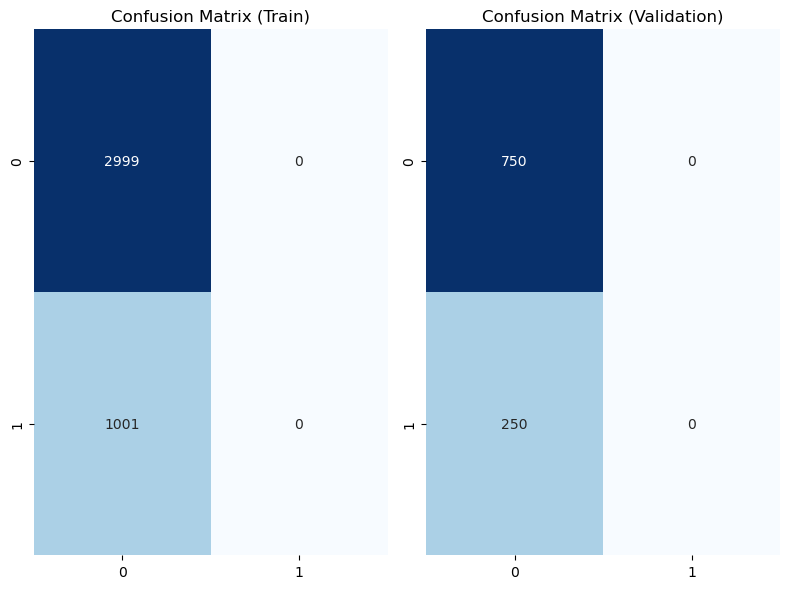

In [150]:
eval_cm(lgbm_clf,X_train,y_train,X_val,y_val)

In [151]:
experiment_name = unique_name_from_base("mlops-pharma-usecase")
run_name = "LGBM-run-v2"
print(experiment_name)

mlops-pharma-usecase-1714655882-2f82


In [152]:
# %%time
# Create an experiment and start a new run
with Run(experiment_name=experiment_name, run_name=run_name, sagemaker_session=Session()) as run:
    # Define hyperparameters dictionary
    hyperparameters = best_hyperparams

    # Log parameters using the hyperparameters dictionary
    run.log_parameters(
        {"num_train_samples": len(X_train),
         "num_test_samples": len(X_val)}
    )
    run.log_parameters(hyperparameters)

    # Log metrics
    run.log_metric(name="Train_Accuracy", value=accuracy_train)
    run.log_metric(name="Validation_Accuracy", value=accuracy_val)
    run.log_metric(name="Train_F1", value=f1_train)
    run.log_metric(name="Validation_F1", value=f1_val)

    # run.log_confusion_matrix(y_val,lgbm_clf.predict(X_val),"Confusion-matrix-validation")

    # Define input artifacts (if needed)
    # run.log_file('datasets/input_train.npy', is_output=False)

    # Save and log multiple confusion matrices
    cm_train_path = '../cm_train.png'
    cm_val_path = '../cm_val.png'
    auc_roc_path = '../roc_auc.png'

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_train, lgbm_clf.predict(X_train)), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Train)')
    plt.tight_layout()
    # plt.savefig(cm_train_path)
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_val, lgbm_clf.predict(X_val)), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Validation)')
    plt.tight_layout()
    # plt.savefig(cm_val_path)
    plt.close()

    # Compute ROC curve and ROC area
    probs = lgbm_clf.predict_proba(X_val)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_val, preds)
    roc_auc = auc(fpr, tpr)


    # Creating the ROC curve plot
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC_LGBM= %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()
    # plt.savefig(auc_roc_path)
    plt.close()

    # Log confusion matrix images
    # run.log_confusion_matrix(y_train, lgbm_clf.predict(X_train), 'Confusion-Matrix-Train')
    run.log_confusion_matrix(y_val, lgbm_clf.predict(X_val), 'Confusion-Matrix-Validation')

    # Log confusion matrix images as artifacts
    run.log_file(cm_train_path, is_output = False)
    run.log_file(cm_val_path,  is_output = False)
    run.log_file(auc_roc_path,  is_output = False)


### Classifier 2 - XGB Classifier


In [153]:
space = {
    "max_depth": hp.quniform("max_depth", 3, 8, 1),  # Uniformly sample from integers between 3 and 20
    "gamma": hp.uniform("gamma", 0, 0.0005),  # Uniformly sample from a continuous range between 0 and 0.0005
    "subsample": hp.uniform("subsample", 0.1, 1),  # Uniformly sample from a continuous range between 0.1 and 1
    "colsample_bytree": 0.8011137517906433,  # Keep this value fixed
    "reg_alpha": hp.uniform("reg_alpha", np.log(10), np.log(100)),  # Log-uniform sampling between log(0.01) and log(1)
}


In [154]:
def train_evaluate(params):
    # Create an XGBoost model
    params["max_depth"] = int(params["max_depth"])
    model = xgb.XGBClassifier(**params, random_state=321)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred)
    
    return -score  # Minimize the negative of F1-score

# Initialize Trials for hyperparameter optimization
trials = Trials()

# Use Hyperopt to search for the best hyperparameters
best_xgb_param = fmin(fn=train_evaluate, space=space, algo=tpe.suggest, max_evals=30)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001199 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  3%|▎         | 1/30 [00:01<00:33,  1.15s/trial, best loss: -0.6284584980237155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002180 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.628458


  7%|▋         | 2/30 [00:02<00:27,  1.01trial/s, best loss: -0.6284584980237155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001974 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.628458


 10%|█         | 3/30 [00:02<00:25,  1.06trial/s, best loss: -0.640625]          

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002518 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.640625


 13%|█▎        | 4/30 [00:04<00:26,  1.01s/trial, best loss: -0.640625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002546 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.640625


 17%|█▋        | 5/30 [00:04<00:21,  1.16trial/s, best loss: -0.640625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002072 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.640625


 20%|██        | 6/30 [00:05<00:20,  1.16trial/s, best loss: -0.640625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003402 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.640625


 23%|██▎       | 7/30 [00:06<00:20,  1.13trial/s, best loss: -0.640625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002574 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.640625


 27%|██▋       | 8/30 [00:06<00:16,  1.32trial/s, best loss: -0.640625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001909 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.640625


 30%|███       | 9/30 [00:07<00:16,  1.28trial/s, best loss: -0.640625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002065 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.640625


 33%|███▎      | 10/30 [00:08<00:15,  1.33trial/s, best loss: -0.640625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002298 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.640625


 37%|███▋      | 11/30 [00:09<00:15,  1.22trial/s, best loss: -0.6600790513833992]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001858 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.660079


 40%|████      | 12/30 [00:09<00:12,  1.44trial/s, best loss: -0.6600790513833992]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002053 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.660079


 43%|████▎     | 13/30 [00:10<00:12,  1.36trial/s, best loss: -0.6600790513833992]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003033 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.660079


 47%|████▋     | 14/30 [00:11<00:11,  1.43trial/s, best loss: -0.66015625]        

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002226 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.660156


 50%|█████     | 15/30 [00:11<00:10,  1.45trial/s, best loss: -0.6626746506986028]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002580 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.662675


 53%|█████▎    | 16/30 [00:12<00:09,  1.50trial/s, best loss: -0.6626746506986028]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002272 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.662675


 57%|█████▋    | 17/30 [00:13<00:10,  1.26trial/s, best loss: -0.6626746506986028]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002913 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.662675


 60%|██████    | 18/30 [00:14<00:11,  1.07trial/s, best loss: -0.6626746506986028]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002202 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.662675


 63%|██████▎   | 19/30 [00:15<00:10,  1.08trial/s, best loss: -0.6626746506986028]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002021 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.662675


 67%|██████▋   | 20/30 [00:16<00:09,  1.03trial/s, best loss: -0.6626746506986028]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007428 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.662675


 70%|███████   | 21/30 [00:17<00:07,  1.21trial/s, best loss: -0.6679611650485436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003402 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.667961


 73%|███████▎  | 22/30 [00:17<00:05,  1.38trial/s, best loss: -0.6757281553398058]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002371 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.675728


 77%|███████▋  | 23/30 [00:18<00:04,  1.52trial/s, best loss: -0.6757281553398058]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002450 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.675728


 80%|████████  | 24/30 [00:18<00:03,  1.60trial/s, best loss: -0.6757281553398058]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002660 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.675728


 83%|████████▎ | 25/30 [00:19<00:02,  1.72trial/s, best loss: -0.6782273603082851]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002873 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.678227


 87%|████████▋ | 26/30 [00:19<00:02,  1.78trial/s, best loss: -0.6782273603082851]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002012 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.678227


 90%|█████████ | 27/30 [00:20<00:01,  1.92trial/s, best loss: -0.6782273603082851]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002339 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.678227


 93%|█████████▎| 28/30 [00:21<00:01,  1.66trial/s, best loss: -0.6782273603082851]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004180 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.678227


 97%|█████████▋| 29/30 [00:21<00:00,  1.70trial/s, best loss: -0.6950092421441775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004725 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.695009


100%|██████████| 30/30 [00:22<00:00,  1.34trial/s, best loss: -0.6950092421441775]


In [155]:
print(best_xgb_param)

{'gamma': 5.0047259779731584e-05, 'max_depth': 3.0, 'reg_alpha': 2.317446179380346, 'subsample': 0.9971173939476404}


In [156]:
# Extract the best hyperparameters from the search results
best_hyperparams = {
    'subsample': float(best_xgb_param['subsample']),
    'max_depth': int(best_xgb_param['max_depth']),
    'reg_alpha': float(best_xgb_param['reg_alpha']),
    'gamma': float(best_xgb_param['gamma'])
}

In [157]:
# model fit
xgb_clf = xgb.XGBClassifier(**best_hyperparams)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.0047259779731584e-05, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [158]:
f1_train, accuracy_train, f1_val, accuracy_val = evaluate_model(xgb_clf, X_train, y_train, X_val, y_val)
print("Training Set:")
print("F1-score:", f1_train)
print("Accuracy:", accuracy_train)
print("\nValidation Set:")
print("F1-score:", f1_val)
print("Accuracy:", accuracy_val)


Training Set:
F1-score: 0.8948609146628949
Accuracy: 0.94425

Validation Set:
F1-score: 0.7012987012987013
Accuracy: 0.839


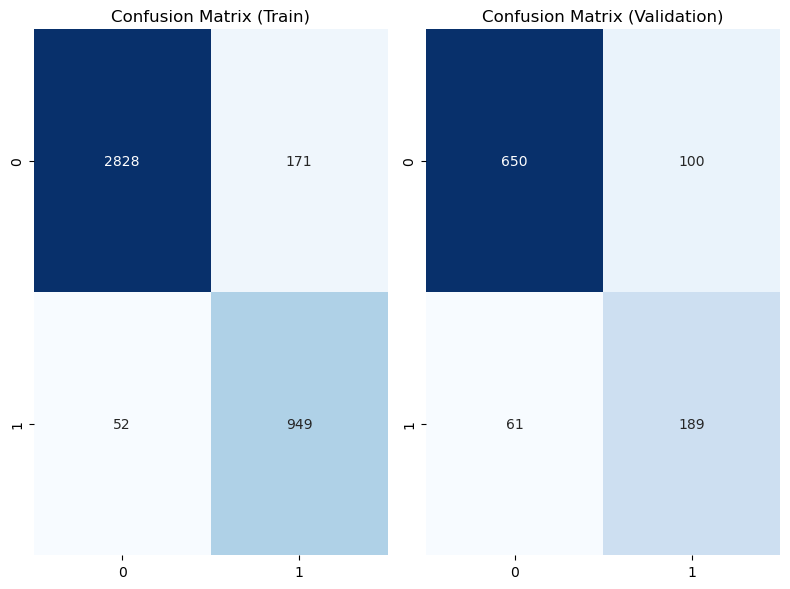

In [159]:
eval_cm(xgb_clf,X_train,y_train,X_val,y_val)

In [165]:
experiment_name = unique_name_from_base("mlops-pharma-usecase")
run_name = "XGB-run"
print(experiment_name)

mlops-pharma-usecase-1714656104-4005


In [166]:
#%%time
# Create an experiment and start a new run
with Run(experiment_name=experiment_name, run_name=run_name, sagemaker_session=Session()) as run:
    # Define hyperparameters dictionary
    hyperparameters = best_hyperparams

    # Log parameters using the hyperparameters dictionary
    run.log_parameters(
        {"num_train_samples": len(X_train),
         "num_test_samples": len(X_val)}
    )
    run.log_parameters(hyperparameters)

    # Log metrics
    run.log_metric(name="Train_Accuracy", value=accuracy_train)
    run.log_metric(name="Validation_Accuracy", value=accuracy_val)
    run.log_metric(name="Train_F1", value=f1_train)
    run.log_metric(name="Validation_F1", value=f1_val)

    # run.log_confusion_matrix(y_val,lgbm_clf.predict(X_val),"Confusion-matrix-validation")

    # Define input artifacts (if needed)
    # run.log_file('datasets/input_train.npy', is_output=False)

    # Save and log multiple confusion matrices
    # cm_train_path = '../xgb/cm_train.png'
    # cm_val_path = '../xgb/cm_val.png'
    # auc_roc_path = '../xgb/roc_auc.png'

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_train, xgb_clf.predict(X_train)), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Train)')
    plt.tight_layout()
    # plt.savefig(cm_train_path)
    plt.close()

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_val, xgb_clf.predict(X_val)), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Validation)')
    plt.tight_layout()
    # plt.savefig(cm_val_path)
    plt.close()

    # Compute ROC curve and ROC area
    probs = lgbm_clf.predict_proba(X_val)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_val, preds)
    roc_auc = auc(fpr, tpr)


    # Creating the ROC curve plot
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC_XGB= %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()
    # plt.savefig(auc_roc_path)
    plt.close()

    # Log confusion matrix images
    # run.log_confusion_matrix(y_train, lgbm_clf.predict(X_train), 'Confusion-Matrix-Train')
    run.log_confusion_matrix(y_val, lgbm_clf.predict(X_val), 'XGB-Confusion-Matrix-Validation')

    # Log confusion matrix images as artifacts
    # run.log_file(cm_train_path, is_output = False)
    # run.log_file(cm_val_path,  is_output = False)
    # run.log_file(auc_roc_path,  is_output = False)
